# Table of Content

1. [Introduction](#intro)

2. [Explore, clean, improve and check dataset](#explore)
    - [Explore dataset](#explore)
    - [Clean dataset](#clean)
    - [Improve dataset](#improve)
    - [Outliers detection](#check)

3. [Features ranking](#features_select)
    - [Preliminary exploration](#features_select_explore)
    - [Filter methods](#features_filter)
    - [RFE methods](#features_RFE)
    - [Embedded methods](#features_embed)

4. [Classifiers evaluation](#classif_eval)
    - [Validation of classifiers versus features selection methods](#classif_eval_feat)
    - [Tuning of classifiers](#classif_eval_tuning)
    - [Final cross-validation](#classif_final_cv)    

5.  [Conclusion](#conclusion)

6.  [Answers to questions](#questions)

# Introduction
<a id="intro"></a>

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project,  using machine learning tehcniques, we'll attemp to predict and spot persons of interest(POI) based on financial and email data made public as a result of the Enron scandal. A person of interest in the fraud case, means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.  

Ressources available for this classifcation are:
 - POI labels: the list of persons of interest,which has been hand-generated based on various public ressources. 
 - financial features extracted from a PDF file summarizing all payments and stocks values of each employee involved in the lawsuit.
 - emails features describing the volume of emails exchanged with POI , which have been processed from email database

All these data have already been pre-processed into a Python dictionnary.

In [1]:
# Number of cores of your CPU (speed up some sklearn functions execution)
CPU_CORE=4

In [2]:
import sys
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import graphviz

# Explore, clean an improve dataset
<a id="explore"></a>

In this section, we'll explore the dataset, clean it and improve it by creating some additonal 'engineering features'.

## Explore dataset

The dataset is transformed into a Panda dataframe to ease its exploration.

In [3]:
# labels of fatures are defined in following lists:
EMAILS=['to_messages', 
        'email_address', 
        'from_poi_to_this_person', 
        'from_messages', 
        'from_this_person_to_poi', 
        'shared_receipt_with_poi']

STOCK_VALUE=['exercised_stock_options',
             'restricted_stock',
             'restricted_stock_deferred', 
             'total_stock_value']
                    
PAYMENTS=['salary', 
          'bonus',
          'long_term_incentive',
          'deferred_income',
          'deferral_payments', 
          'loan_advances',
          'other', 
          'expenses', 
          'director_fees',
          'total_payments']
#
FEATURES=PAYMENTS+STOCK_VALUE+EMAILS

In [4]:
with open("final_project_dataset.pkl", "rb") as data_file:
   data_dict = pickle.load(data_file)

# working with pandas makes things easier
df=pd.DataFrame(data_dict).transpose()

# Replacing NaN per numpy NaN
def replace_nan(s):
    if s=='NaN':
        return(np.nan)
    else:
        return(s)      
    
df=df.applymap(replace_nan)

The dataset is composed of:
- 146 employees including 18 POIs
- 20 features including:
    - 6 features related to e-mails to/from POI
    - 14 financial features icluding 4 related to stocks
- 1 label 'poi' containing two classes: POI or non-POIs (which is a column of the dataframe)

In [5]:
df.shape

(146, 21)

In [6]:
sum(df.poi)

18

In [7]:
df.columns

Index(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'email_address', 'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
       'long_term_incentive', 'other', 'poi', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

In [8]:
df.transpose()

,METTS MARK,BAXTER JOHN C,ELLIOTT STEVEN,CORDES WILLIAM R,HANNON KEVIN P,MORDAUNT KRISTINA M,MEYER ROCKFORD G,MCMAHON JEFFREY,HAEDICKE MARK E,PIPER GREGORY F,...,SAVAGE FRANK,IZZO LAWRENCE L,TILNEY ELIZABETH A,MARTIN AMANDA K,BUY RICHARD B,GRAMM WENDY L,CAUSEY RICHARD A,TAYLOR MITCHELL S,DONAHUE JR JEFFREY M,GLISAN JR BEN F
bonus,600000,1.2e+06,350000,NaN,1.5e+06,325000,NaN,2.6e+06,1.15e+06,400000,...,NaN,NaN,300000,NaN,900000,NaN,1e+06,600000,800000,600000
deferral_payments,NaN,1.29574e+06,NaN,NaN,NaN,NaN,1.84823e+06,NaN,2.15753e+06,1.13004e+06,...,NaN,NaN,NaN,85430,649584,NaN,NaN,227449,NaN,NaN
deferred_income,NaN,-1.38606e+06,-400729,NaN,-3.11701e+06,NaN,NaN,NaN,-934484,-33333,...,-121284,NaN,-575000,NaN,-694862,NaN,-235000,NaN,-300000,NaN
director_fees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,125034,NaN,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN
email_address,mark.metts@enron.com,NaN,steven.elliott@enron.com,bill.cordes@enron.com,kevin.hannon@enron.com,kristina.mordaunt@enron.com,rockford.meyer@enron.com,jeffrey.mcmahon@enron.com,mark.haedicke@enron.com,greg.piper@enron.com,...,NaN,larry.izzo@enron.com,elizabeth.tilney@enron.com,a..martin@enron.com,rick.buy@enron.com,NaN,richard.causey@enron.com,mitchell.taylor@enron.com,jeff.donahue@enron.com,ben.glisan@enron.com
exercised_stock_options,NaN,6.68054e+06,4.89034e+06,651850,5.538e+06,NaN,493489,1.10405e+06,608750,880290,...,NaN,2.16517e+06,591250,2.07031e+06,2.54281e+06,NaN,NaN,3.18125e+06,765920,384728
expenses,94299,11200,78552,NaN,34039,35018,NaN,137108,76169,43057,...,NaN,28093,NaN,8211,NaN,NaN,30674,NaN,96268,125978
from_messages,29,NaN,NaN,12,32,NaN,28,48,1941,222,...,NaN,19,19,230,1053,NaN,49,29,22,16
from_poi_to_this_person,38,NaN,NaN,10,32,NaN,0,58,180,61,...,NaN,28,10,8,156,NaN,58,0,188,52
from_this_person_to_poi,1,NaN,NaN,0,21,NaN,0,26,61,48,...,NaN,5,11,0,71,NaN,12,0,11,6


##  Cleaning dataset
<a id="clean"></a>

### Replacing NaN values

There are a lot of 'NaN' in the dataset. Let's explore how are distributed these 'NaN' among the dataset. We'll start with the global ratio and explore per features and employees.

In [9]:
print('Total %% of NaN in the dataset= %1.1f' % (df.isna().sum().sum()/df.shape[1]/df.shape[0]*100),'%')

Total % of NaN in the dataset= 44.3 %


In [10]:
print('TOP 10 employees ranked per % of NaN')
(df[FEATURES].isna().sum(axis=1)/df[FEATURES].shape[1]*100).sort_values(ascending=False)[0:15]

TOP 10 employees ranked per % of NaN


LOCKHART EUGENE E                100.0
THE TRAVEL AGENCY IN THE PARK     90.0
GRAMM WENDY L                     90.0
WHALEY DAVID A                    90.0
WROBEL BRUCE                      90.0
SAVAGE FRANK                      85.0
WAKEHAM JOHN                      85.0
WODRASKA JOHN                     85.0
GILLIS JOHN                       85.0
SCRIMSHAW MATTHEW                 85.0
CLINE KENNETH W                   85.0
URQUHART JOHN A                   80.0
GATHMANN WILLIAM D                80.0
PEREIRA PAULO V. FERRAZ           80.0
WINOKUR JR. HERBERT S             80.0
dtype: float64

In [11]:
# record for future use in feature selection
print('Features ranked per % of NaN')
nan_per_feature=(df[FEATURES].isna().sum()/df[FEATURES].shape[0]*100).sort_values(ascending=False)
nan_per_feature

Features ranked per % of NaN


loan_advances                97.260274
director_fees                88.356164
restricted_stock_deferred    87.671233
deferral_payments            73.287671
deferred_income              66.438356
long_term_incentive          54.794521
bonus                        43.835616
shared_receipt_with_poi      41.095890
from_messages                41.095890
from_poi_to_this_person      41.095890
to_messages                  41.095890
from_this_person_to_poi      41.095890
other                        36.301370
salary                       34.931507
expenses                     34.931507
exercised_stock_options      30.136986
restricted_stock             24.657534
email_address                23.972603
total_payments               14.383562
total_stock_value            13.698630
dtype: float64

As we can see above , the dataset is heavily populated with NaN (about 45%). Removing all rows or columns with NaN is not suitable as it would result in an almost empty dataset. Two different ways for replacing these NaN values have been considered depending on the category of the feature:
- for financial data (payments & stocks),  as a dash corresponds to a null amount into the PDF financial file, NaN have been replaced by zeros.
- for emails statistics, these values are unknown and it sounds smarter to replace by the median of each population (POI/non-POI)

There are also employees who have a very high ratio of NaN. At this stage, we'll only remove 'LOCKHART EUGENE E' (100% of NaN) and 'THE TRAVEL AGENCY IN THE PARK' (which is obviously not an employee)

In [12]:
# filling financial features NaN with zeros
df[PAYMENTS]=df[PAYMENTS].fillna(0)
df[STOCK_VALUE]=df[STOCK_VALUE].fillna(0)

# filling EMAILS NaN features with the median of population
poi=df[df.poi].index.values
not_poi=df[~df.poi].index.values
df.loc[poi,EMAILS]=df[df.poi][EMAILS].fillna(df[df.poi][EMAILS].median())
df.loc[not_poi,EMAILS]=df[~df.poi][EMAILS].fillna(df[~df.poi][EMAILS].median())

# Removing Eugene whose fatures are fully filled with NaN values
df=df.drop('LOCKHART EUGENE E',axis=0)
# and the travel agency
df=df.drop('THE TRAVEL AGENCY IN THE PARK',axis=0)

For each employee, we checked if the sum of financial features (stocks and payments) equals the total provided.

In [13]:
df[~((df[STOCK_VALUE[:-1]].sum(axis=1)==df[STOCK_VALUE[-1]])|(df[PAYMENTS[:-1]].sum(axis=1)==df[PAYMENTS[-1]]))]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
BELFER ROBERT,0.0,-102500.0,0.0,3285.0,NaN,3285.0,0.0,41.0,26.5,6.0,...,0.0,0.0,False,0.0,44093.0,0.0,594.0,944.0,102500.0,-44093.0
BHATNAGAR SANJAY,0.0,0.0,0.0,137864.0,sanjay.bhatnagar@enron.com,2604490.0,0.0,29.0,0.0,1.0,...,0.0,137864.0,False,-2604490.0,15456290.0,0.0,463.0,523.0,15456290.0,0.0


In [14]:
# correct values
df.loc['BELFER ROBERT',PAYMENTS]=[0,0,0,-102500,0,0,0,3285,102500,3285]
df.loc['BELFER ROBERT',STOCK_VALUE]=[0,44093,-44093,0]
df.loc['BHATNAGAR SANJAY',PAYMENTS]=[0,0,0,0,0,0,0,137864,0,137864]
df.loc['BHATNAGAR SANJAY',STOCK_VALUE]=[15456290,2604490,-2604490,15456290]
# cross-check
df[~((df[STOCK_VALUE[:-1]].sum(axis=1)==df[STOCK_VALUE[-1]])|(df[PAYMENTS[:-1]].sum(axis=1)==df[PAYMENTS[-1]]))]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value


Finally, we decided to remove features with a very high ratio of NaN, e.g loan_advances, director_fees and restricted_stock_deferred. This decision might seem a bit premature but it has also been confirmed by preliminary features exploration (few data and highly skewed ditributions) and selection phase (features with very low importance). Before removing these features, we need to pay attention to the value of associated totals:
- loan_advances and director_fees needs to be substracted from total_payments
- restricted_stock_deferred needs to be substracted from total_stock_value

In [15]:
# drop loan advances
df.total_payments=df.total_payments-df.loan_advances
df=df.drop('loan_advances',axis=1)
PAYMENTS.remove('loan_advances')
FEATURES.remove('loan_advances')

df.total_payments=df.total_payments-df.director_fees
df=df.drop('director_fees',axis=1)
PAYMENTS.remove('director_fees')
FEATURES.remove('director_fees')

df.total_stock_value = df.total_stock_value - df.restricted_stock_deferred
df=df.drop('restricted_stock_deferred',axis=1)
STOCK_VALUE.remove('restricted_stock_deferred')
FEATURES.remove('restricted_stock_deferred')

# Cross-check
df.isna().sum()

bonus                       0
deferral_payments           0
deferred_income             0
email_address              33
exercised_stock_options     0
expenses                    0
from_messages               0
from_poi_to_this_person     0
from_this_person_to_poi     0
long_term_incentive         0
other                       0
poi                         0
restricted_stock            0
salary                      0
shared_receipt_with_poi     0
to_messages                 0
total_payments              0
total_stock_value           0
dtype: int64

NaN are still lefting for 'email-address'. This feature contains no information apart employee's name and can be removed.

In [16]:
df=df.drop('email_address',axis=1)
EMAILS.remove('email_address')
FEATURES.remove('email_address')

## Improve dataset
<a id="improve"></a>
In the section, we introduce some 'enginering' features for each category.

### EMAILS engineering features

EMAILS features need some normalization. The total number of from/to messages is likely irrelevant for this analysis. What matters is the level of interaction between the employee and POIs. Such features can easily be extracted by calculating the ratio betweeen messages related to POIs and the total number of messages. In addition, we have introduced a new feature which is the total number of emails to/from POI divided by the total number of emails.

Total of messages (from/to) features could likely be removed as they likely contain no information. But this decision is postopoend to the feature selection phase. 

In [17]:
df['email_ratio_poi']=(df.from_poi_to_this_person+df.from_this_person_to_poi)/(df.from_messages+df.to_messages)
df['from_poi_ratio']=df.from_poi_to_this_person/df.to_messages
df['to_poi_ratio']=df.from_this_person_to_poi/df.from_messages
df['shared_poi_ratio']=df.shared_receipt_with_poi/df.to_messages

EMAILS_RATIO = ['email_ratio_poi','from_poi_ratio','to_poi_ratio','shared_poi_ratio']

# update list of features
FEATURES += EMAILS_RATIO

### Financial features

We chose a 'bulk' approach to create financial engineering features:
- ratio between each financial feature and corresponding total is created
- ratio of total payments and total stocks values to the total sum is created. It is noteworthy that two employees have a sum of stocks / payments which is null, but we choose to keep them in the dataset. For these two cases, these engineering features are set to the null value

In [18]:
# custom normalization to avoid division per zero
def normalize_to_max(row):
    total=row[-1]
    max=total
    if max==0.0:
        max = row.max()
    if max==0.0:
        max = 1
    result = row/max
    result[-1] = total
    return result

STOCK_VALUE_RATIO=[s+'_ratio' for s in STOCK_VALUE]
PAYMENTS_RATIO=[s+'_ratio' for s in PAYMENTS]

# Normalize stock features per total (or max if total is null)
df[STOCK_VALUE_RATIO]=df[STOCK_VALUE].apply(normalize_to_max,axis=1)
# Normalize payments -same method-
df[PAYMENTS_RATIO]=df[PAYMENTS].apply(normalize_to_max,axis=1)
df=df.drop(STOCK_VALUE_RATIO[-1],axis=1)
df=df.drop(PAYMENTS_RATIO[-1],axis=1)

df['ratio_payment']=df[PAYMENTS[-1]]/(df[STOCK_VALUE[-1]]+df[PAYMENTS[-1]])
df['ratio_stocks']=df[STOCK_VALUE[-1]]/(df[STOCK_VALUE[-1]]+df[PAYMENTS[-1]])
# Two employees have null divider
df=df.fillna(0)

# Updating features lists
STOCK_VALUE_RATIO=[s+'_ratio' for s in STOCK_VALUE[:-1]]
PAYMENTS_RATIO=[s+'_ratio' for s in PAYMENTS[:-1]]
STOCK_VALUE_RATIO += ['ratio_stocks']
PAYMENTS_RATIO += ['ratio_payment']
FEATURES += PAYMENTS_RATIO + STOCK_VALUE_RATIO

## Outliers detection
<a id="check"></a>

An obvious outlier is TOTAL, it can be easily be found by any univariate plotting of a financial feature and we chose to remove it directly at this stage.

In [19]:
df=df.drop('TOTAL',axis=0)

Visualisation of outliers candidates is based on the interquartile range which is calculated below:

In [20]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
med=df.median()
iqr = q3-q1 #Interquartile range
low  = med-1.5*iqr
high = med+1.5*iqr

In [21]:
outliers_per_employee=((df[FEATURES]<low).sum(axis=1)+(df[FEATURES]>high).sum(axis=1)).sort_values(ascending=False)
print(' %','of employees with outliers=%1.1f' % ((outliers_per_employee>0).sum()/df.shape[0]*100),'%')
print('\n % of outliers per features:')
(((df<low).sum(axis=0)+(df>high).sum(axis=0))/df.shape[0]*100).sort_values(ascending=False)

 % of employees with outliers=93.7 %

 % of outliers per features:


from_poi_ratio                   41.258741
deferred_income_ratio            33.566434
email_ratio_poi                  31.468531
shared_poi_ratio                 26.573427
deferral_payments_ratio          24.475524
deferral_payments                24.475524
from_messages                    23.776224
deferred_income                  23.776224
other_ratio                      23.076923
shared_receipt_with_poi          21.678322
other                            19.580420
to_messages                      19.580420
total_stock_value                18.181818
from_poi_to_this_person          17.482517
from_this_person_to_poi          17.482517
expenses_ratio                   16.783217
exercised_stock_options          16.783217
long_term_incentive              15.384615
restricted_stock                 13.986014
poi                              12.587413
long_term_incentive_ratio        12.587413
total_payments                    9.790210
bonus                             9.790210
to_poi_rati

All features and employees present an important number of outliers. We'll do some explorations below, but we don't expect to remove much outliers. Actually they should be part of the distribution.

In [22]:
# This function plot histograms of distribution for each feature in a list
def plot_histograms(features):
    outliers_per_feature=((df[features]<low[features]).sum(axis=0)+(df[features]>high[features]).sum(axis=0)).sort_values(ascending=False)
    df_poi=df[df.poi]
    poi_list=df_poi.index.values
    for feature in features:
        plt.figure(figsize=(16,1.5))
        plt.subplot(121)
        ax=df[feature].hist(bins=50)
        handles, labels = ax.get_legend_handles_labels()
        for poi in poi_list:
            ax,=plt.plot(df_poi.loc[poi,feature],0,'ro')

        handles += [ax]
        labels += ['poi']

        ax=plt.axvline(high[feature],color='red')
        handles += [ax]
        labels += ['Q3+1.5*IQ']

        ax=plt.axvline(low[feature],color='red',linestyle=':')
        handles += [ax]
        labels += ['Q3-1.5*IQ']

        plt.xlabel(feature)
        plt.ylabel('number')
        plt.legend(handles,labels)  
        plt.subplot(122)
        ax = sns.boxplot(x="poi", y=feature, hue="poi",data=df)
        plt.grid()

def rank_n(feature,n=10,asc=False):
    return(df.loc[:,feature+['poi']].sort_values(by=feature[0],ascending=asc)[0:n])

We'll explore per feature groups: Let's start by EMAILS features

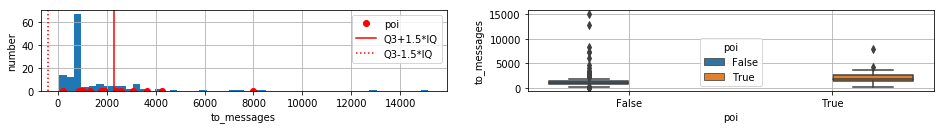

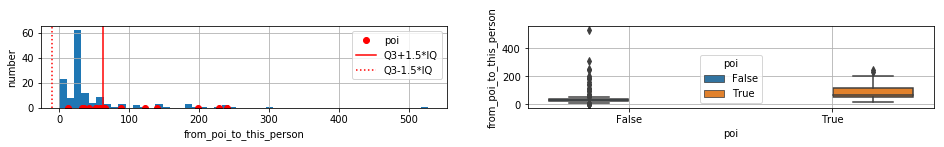

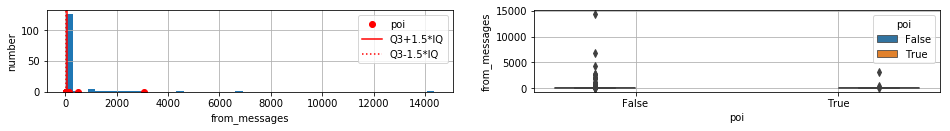

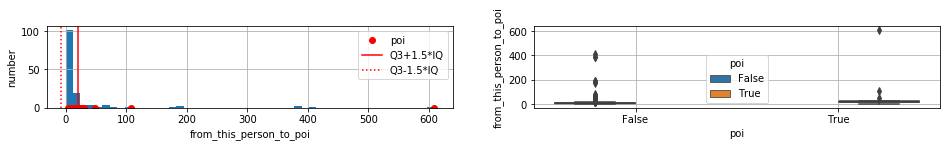

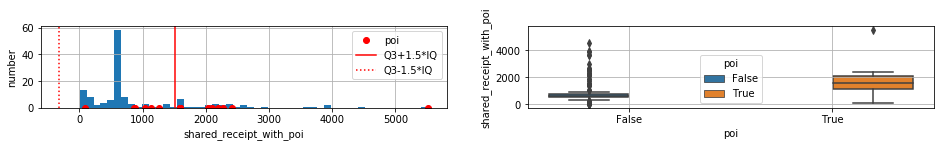

In [23]:
plot_histograms(EMAILS)

In [24]:
rank_n(["from_messages","to_messages","from_poi_ratio","to_poi_ratio","shared_poi_ratio"],5,False)

,from_messages,to_messages,from_poi_ratio,to_poi_ratio,shared_poi_ratio,poi
KAMINSKI WINCENTY J,14368.0,4607.0,0.008900,0.011901,0.126547,False
KEAN STEVEN J,6759.0,12754.0,0.010977,0.057257,0.285322,False
BECK SALLY W,4343.0,7315.0,0.019686,0.088879,0.360766,False
DELAINEY DAVID W,3069.0,3093.0,0.021339,0.198436,0.677983,True
MCCONNELL MICHAEL S,2742.0,3329.0,0.027636,0.070751,0.657555,False


As we can see in the table above, even if some employees have a huge number of emails, ratios seems quite consistent. These potential outliers are not removed from the dataset.

Most interesting features, e.g presenting a visible discrimination between POI and non-POIS employees are 'from_poi_to_this_person' and 'shared_receipt_with_poi'. These two features are likely important contributors for the classification. 

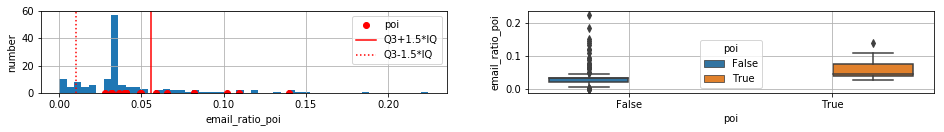

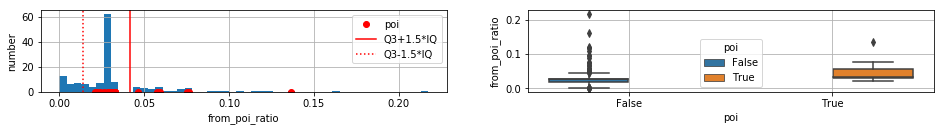

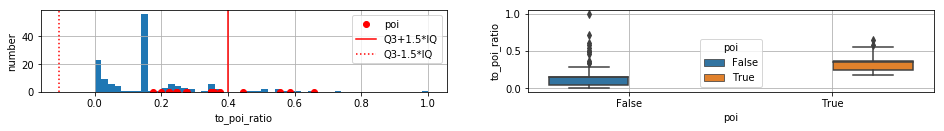

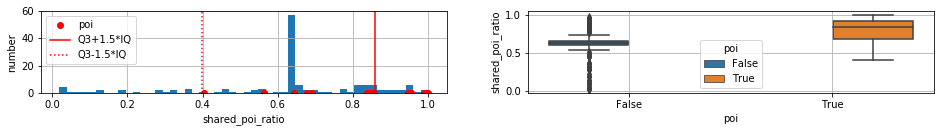

In [25]:
plot_histograms(EMAILS_RATIO)

In [26]:
rank_n(['shared_poi_ratio','shared_receipt_with_poi','to_messages'],n=5)

,shared_poi_ratio,shared_receipt_with_poi,to_messages,poi
GLISAN JR BEN F,1.001145,874.0,873.0,True
HANNON KEVIN P,0.990431,1035.0,1045.0,True
SUNDE MARTIN,0.969022,2565.0,2647.0,False
KOENIG MARK E,0.956613,2271.0,2374.0,True
RICE KENNETH D,0.954696,864.0,905.0,True


GLISAN JR BEN F 'shared_poi_ratio' value needs to be corrected. Actually he has received 873 mails but shares 874 with POI. 

In [27]:
df.loc['GLISAN JR BEN F','shared_poi_ratio']=1.0
df.loc['GLISAN JR BEN F','shared_receipt_with_poi']=873

Apart this correction, outliers are not significant. At the opposite, distribution of ratio features is smoother than distribution of raw features. 

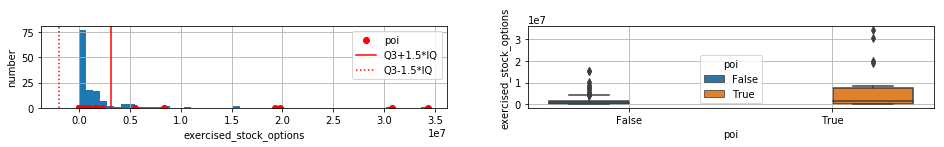

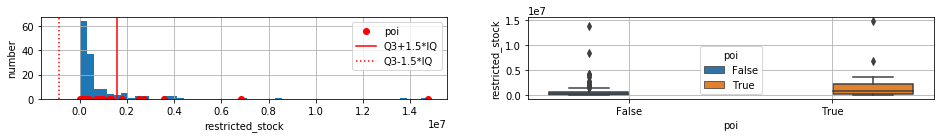

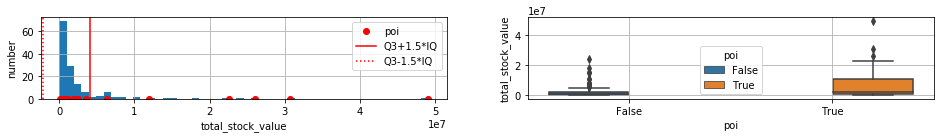

In [28]:
plot_histograms(STOCK_VALUE)

Even if all features' distribution are highly skewed with very narrow and long tails, we can hardly remove any outliers as tails of these distributions are populated with both POIs and non-POIs.

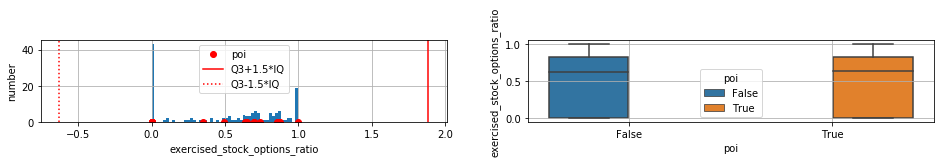

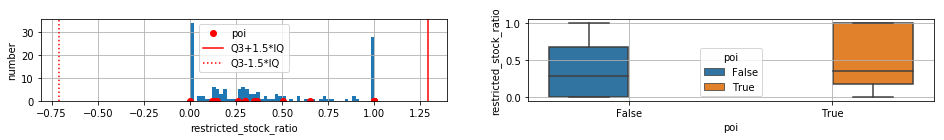

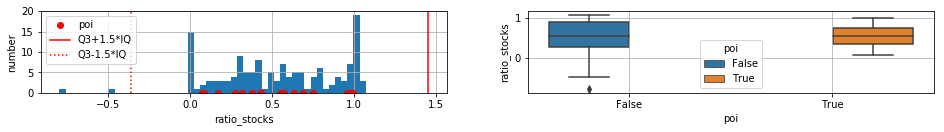

In [29]:
plot_histograms(STOCK_VALUE_RATIO)

Ratio are more normally distributed than raw features but POI/non-POIs are highly overlapped. These engineering features will very likely be useless.

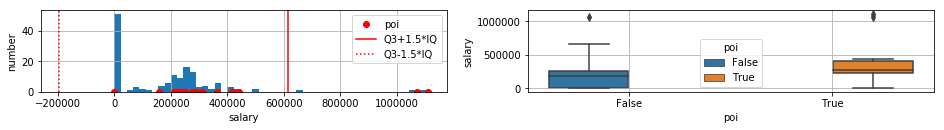

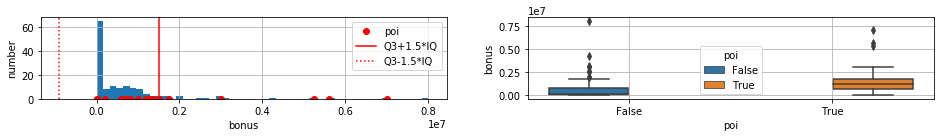

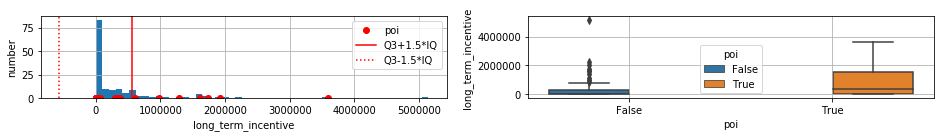

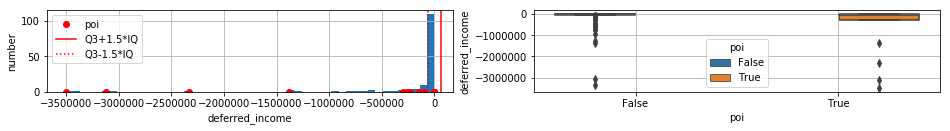

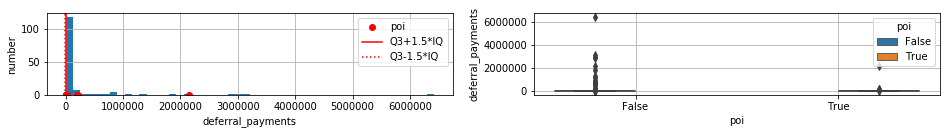

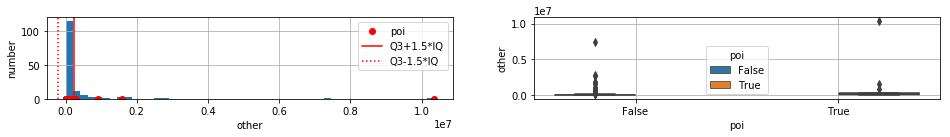

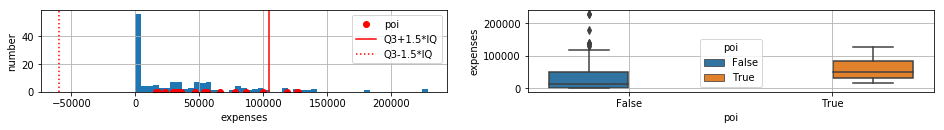

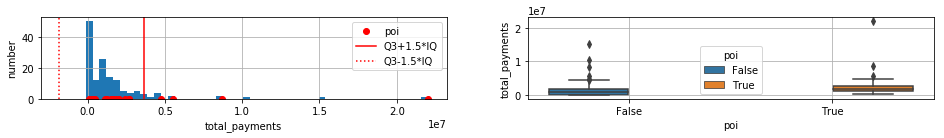

In [30]:
plot_histograms(PAYMENTS)

No obvious outliers can be removed as tail of distribution are populated by both classes. Many of these features present obvious different distribution between POI and non-POIs: bonus, salary, expenses, long_term_incentive.

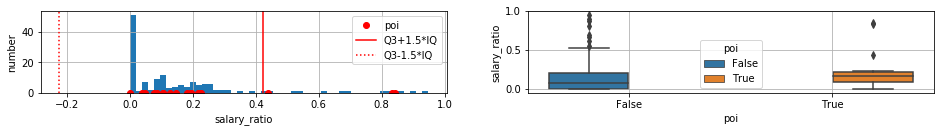

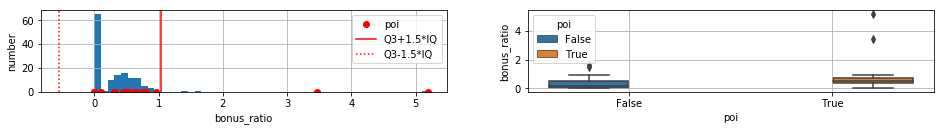

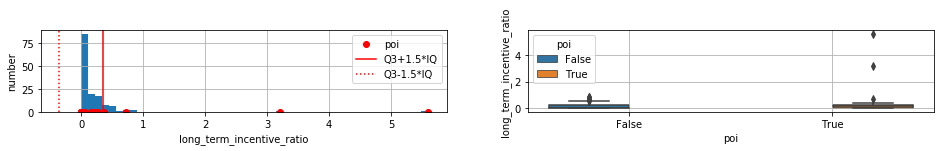

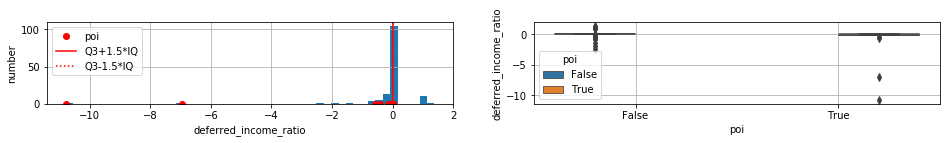

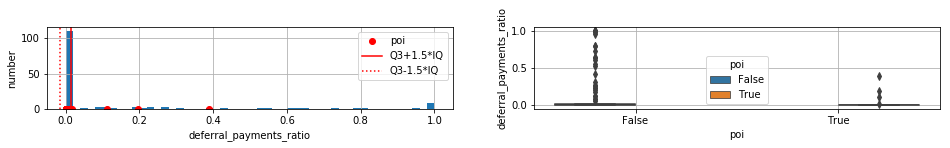

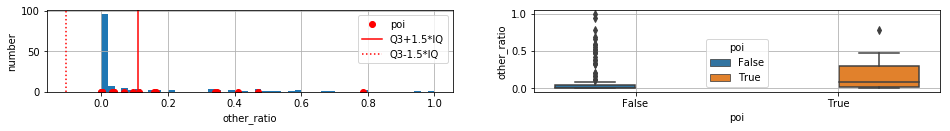

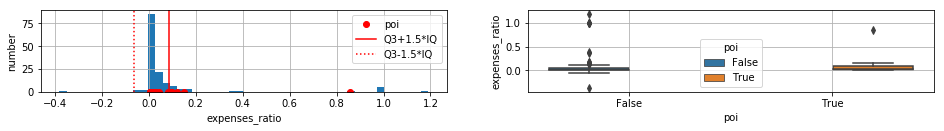

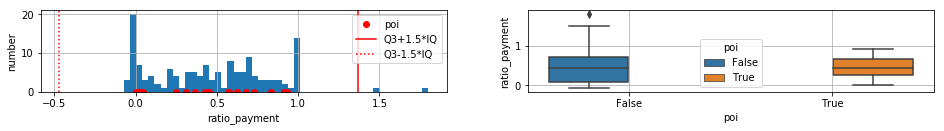

In [31]:
plot_histograms(PAYMENTS_RATIO)

Same conclusions than above hold. Ratio features are less prone to outliers but tend to overlap distribution of both classes. However, for this set of features, the feature 'others_ratio' clearly pops up as a key one.

# Feature selection
<a id='features_select'></a>

Feature selection and ranking is a key step to improve the performance of classifiers. It is particularly crucial for this application as the number of features is high compared to the number of samples. We are somehow facing the https://en.wikipedia.org/wiki/Curse_of_dimensionality. When the number of features increases, the performance increases until the optimal number of features is reached. Further increasing without increasing the size of the dataset results in a decrease in classifier performance. We clearly need to select features in order to:
- select most informative features
- remove uninformative features 
- and ideally limit the number of correlated features.

The feature selection process conducted is largely inspired by this article found on Ando Saabas blog:
https://blog.datadive.net/selecting-good-features-part-i-univariate-selection/
and supported as well by sklearn documentation
https://scikit-learn.org/stable/modules/feature_selection.htmland

As we'll see, there are many techniques of features selection and the technique must be adapted to the algorithm we are going to use for classification.

Feature selection techhniques used for this project can be split into three categories:
- **Filter methods** select features based on intrinsec statistics or criteria; this is to say selection is made regardless of the model 'a priori'. These methods are thus totally independent of the classfication algorithm. Nonetheless depending on the filter method, the performance can highly differ between all different classification algorithms. The advantage of these methods is that they are robust against overfitting but they may fail to select most useful features. For this project, we applied these filter methods to the whole dataset. Thus we'll likely face an overfitting issue. 
- **Wrapper methods** use a backward or forward feature elimination scheme to remove unimportant features recursively. This recursive feature elimination needs to be coupled with a learner (classification algorithm) which can rank features.  This selection method is thus highly dependent of the classification algorithm (learner) used. These methods are efficient to identify most important fatures for a given algorithm but they are prone to overfitting. In addition, as explained in this discussion:
https://stats.stackexchange.com/questions/27750/feature-selection-and-cross-validation
selecting feature on the whole dataset will result in a bias in the performance as data are both used for feature selection and cross-validation. However as the size of the dataset is really small, we'll have almost no choice but performing the feature selection on all of the data. So we'll likley face this issue. The method selected for this project is a backward fetaure elimination: Recursive Feature Eliminiation (RFE).
-  **Embedded methods** are basically a machine learning algorithm that returns a model using a limited number of features. We tried this technique based on follwing classifiers: Logistic Regression and Random Forest

An alternative to feature selection is to reduce the dimensionnality through a Principal Component Analysis (PCA) before training the algorithm. 

## Preliminary exploration
<a id='features_select_explore'></a>

We can evaluate how much features are correlated using below heatmap.

Clearly some features are highly correlated and introducing redundant information into classification algorithm. With such a small sample size compared to the number of features might lead rapidly to accuracy issues. For example, the corelation between 'from_poi_ratio' and 'email_ratio_poi' is very high (above 0.9).

We can also observe that:
- there is a low correlation between emails and financial features
- at the opposite, correlation between payments and stocks is rather high 

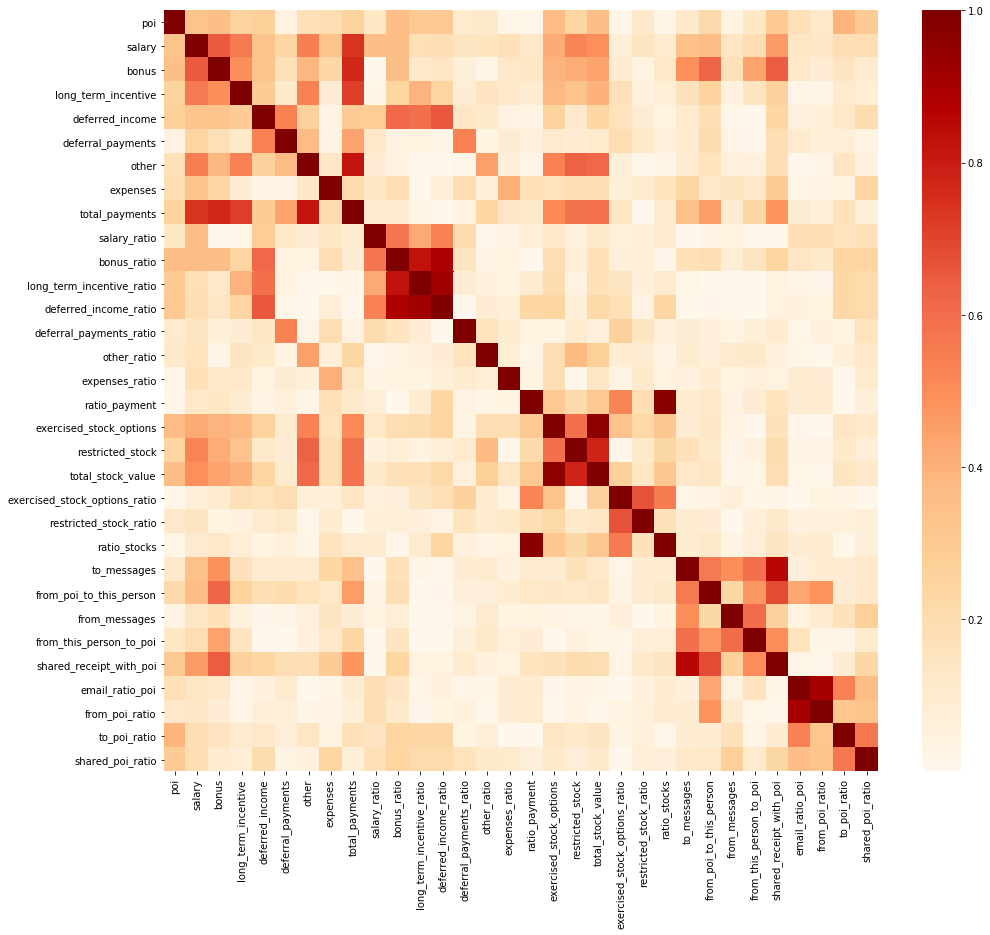

In [32]:
corr=df[['poi']+PAYMENTS+PAYMENTS_RATIO+STOCK_VALUE+STOCK_VALUE_RATIO+EMAILS+EMAILS_RATIO].corr()
plt.figure(figsize=(16,14))
sns.heatmap(abs(corr),cmap="OrRd")

In [33]:
Y = df.poi.values        
X = df[FEATURES].values

In [34]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import RFE,RFECV
from sklearn.tree import ExtraTreeClassifier,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score,f1_score,accuracy_score
from sklearn.linear_model import RandomizedLogisticRegression,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
import math
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
from collections import defaultdict

C:\Users\to101130\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\to101130\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Filter methods
<a id='features_filter'></a>

Following statistical tests have been implemented:
- Pearson correlation coefficient which measure correlation between features 
- ANOVA F-test https://en.wikipedia.org/wiki/F-test
- Mutual information https://en.wikipedia.org/wiki/Mutual_information

Calculation of statistics for features selection is applied on the whole dataset. This method will likely lead to overfitting issues. 

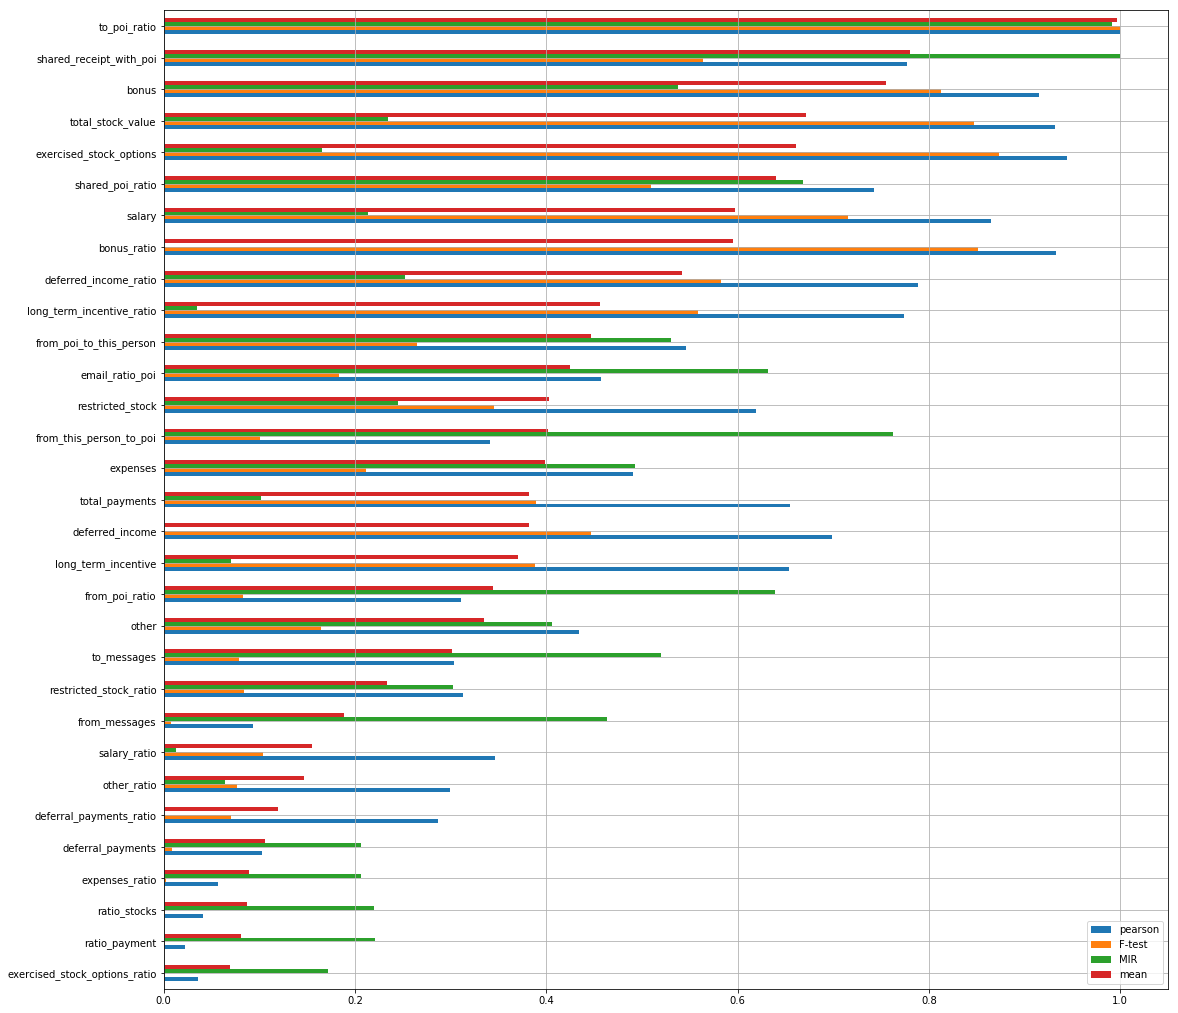

In [35]:
df_feature_score = pd.DataFrame()

pearson=((df[['poi']+FEATURES].corr().abs()).loc['poi'][FEATURES].values)
pearson /= np.max(pearson)
ftest,pval=f_classif(X,Y)
ftest /= np.max(ftest)
mi = mutual_info_classif(X,Y)
mi /= np.max(mi)
df_feature_score=pd.DataFrame({'pearson':pearson,'F-test':ftest,'MIR':mi},index=FEATURES)    
df_feature_score['mean']=df_feature_score.mean(axis=1)
df_feature_score.sort_values('mean',ascending=False)

df_feature_score.sort_values(by='mean',ascending=True).plot(kind='barh',figsize=(18,18),grid=True)

## Recursive feature elimination
<a id='features_rfe'></a>
- Two kind of learners have been used: linear SVC -with L1 penalty- and Decision Tree 
- RFECV has been used because the daset size is really small an this function allows to apply advanced cross-validation.

Cross-validation is based on a stratified shuffle of the dataset. Basically:
- N independent samples of the dataset are randomlmy selected (shuffle fold)
- as the distribution of classes is imbalanced (avout 12% of POIs), these samples are statified, a.g the ratio of POI/non-POIs is approximatively equal to the dataset ratio
- fore each sample, the fold is divided in a train and a test subset with a ratio of 70/30%
- the performance of the algorithm is validated in average for all N folds according to a given scoring (F1, recal
precision ...). Scoring is set to 'F1' as it gives equal importance to precision and recall. We've tried 'recall' as well, but the  resulting selected features can lead to a collapse of precision in particular for SVC algorithm. 

As the size of the dataset is small (about 150 points), cross-validating with a high number of folds is questionnable has it will very likely lead to an overfitting. On the other hand, cross-validating with a low number of folds would very likely lead to a biased selection of features depending on the seed values of random generators. So the first option is preferable in this particular context of an academic study. Nonetheless, we limited the number of cross-validation folds to 100 to try to find a compromise between variance and bias. This parameter can be modified below (N_CV_FEATURE_SELECT).

***NOTE: n_jobs is set to CPU_CORE (constant is defined at the very begining of the notebook) in order to speed up computation duration. Feel free to modifify if you have more cores on your computer (or something goes wrong if you got less ..)***

In [36]:
N_CV_FEATURE_SELECT = 1000

In [37]:
estimators={
            'SVC': LinearSVC(class_weight='balanced',penalty='l1',dual=False),
            'DTC': DecisionTreeClassifier(class_weight='balanced')
            }

for key_est in list(estimators.keys()):

    rfecv = RFECV(estimator=estimators[key_est],
                  cv=StratifiedShuffleSplit(y=Y,n_iter=N_CV_FEATURE_SELECT,test_size=0.3),
                  scoring='f1',
                  n_jobs=CPU_CORE)
    rfecv = rfecv.fit(X,Y)
    last_token ='RFE-'+key_est
    df_feature_score[last_token]=(np.max(rfecv.ranking_)-rfecv.ranking_+1)/np.max(rfecv.ranking_)
   
try:
    df_feature_score=df_feature_score.drop('mean',axis=1)
except:
    print('done')

df_feature_score['mean']=df_feature_score.mean(axis=1)
df_feature_score.sort_values(by=last_token,ascending=False)

,pearson,F-test,MIR,RFE-SVC,RFE-DTC,mean
shared_receipt_with_poi,0.777621,0.564232,1.000000,1.00,1.000000,0.868371
expenses,0.490938,0.211851,0.492730,0.96,1.000000,0.631104
to_poi_ratio,1.000000,1.000000,0.991196,0.64,1.000000,0.926239
from_poi_ratio,0.310513,0.082840,0.638962,0.16,1.000000,0.438463
deferral_payments_ratio,0.286864,0.070547,0.000000,0.12,0.964286,0.288339
long_term_incentive_ratio,0.774205,0.558784,0.034890,0.08,0.928571,0.475290
deferred_income_ratio,0.789057,0.582717,0.252753,0.76,0.892857,0.655477
from_poi_to_this_person,0.546411,0.264862,0.530089,1.00,0.857143,0.639701
bonus_ratio,0.933327,0.851195,0.000000,1.00,0.821429,0.721190
salary_ratio,0.346861,0.103755,0.013384,0.84,0.785714,0.417943


## Embedded methods 
<a id='features_embed'></a>
- based on random Forest classifier
- based on random logistic regression https://scikit-learn.org/stable/modules/feature_selection.html#l1-feature-selection

Once again, we limited the number estimators of samplings to N_CV_FEATURE_SELECT=100 to avoid overfitting.

In [38]:
# Random forest
rf = RandomForestClassifier(n_estimators=N_CV_FEATURE_SELECT,bootstrap=True,class_weight='balanced')
rf=rf.fit(X, Y)
df_feature_score['RF']=rf.feature_importances_/(np.max(rf.feature_importances_))                                                            

# Random Logistic Regression
lr=RandomizedLogisticRegression(n_resampling=N_CV_FEATURE_SELECT,selection_threshold=0,sample_fraction=0.8)
lr=lr.fit(MinMaxScaler().fit_transform(X),Y)    
df_feature_score['RLR']=np.abs(lr.scores_)/np.max(np.abs(lr.scores_))

try:
    df_feature_score=df_feature_score.drop('mean',axis=1)
except:
    print('done')
df_feature_score['mean']=df_feature_score.mean(axis=1)

df_feature_score.sort_values('mean',ascending=False)

C:\Users\to101130\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLogisticRegression is deprecated; The class RandomizedLogisticRegression is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


,pearson,F-test,MIR,RFE-SVC,RFE-DTC,RF,RLR,mean
to_poi_ratio,1.000000,1.000000,0.991196,0.64,1.000000,1.000000,1.000000,0.947314
shared_receipt_with_poi,0.777621,0.564232,1.000000,1.00,1.000000,0.534199,0.275294,0.735907
bonus_ratio,0.933327,0.851195,0.000000,1.00,0.821429,0.064390,0.783529,0.636267
bonus,0.914833,0.812871,0.537732,0.72,0.071429,0.146046,0.651765,0.550668
exercised_stock_options,0.943931,0.873731,0.165824,0.40,0.571429,0.044581,0.698824,0.528331
from_poi_to_this_person,0.546411,0.264862,0.530089,1.00,0.857143,0.438550,0.000000,0.519579
deferred_income_ratio,0.789057,0.582717,0.252753,0.76,0.892857,0.037941,0.284706,0.514290
total_stock_value,0.931458,0.847266,0.235126,0.32,0.642857,0.075718,0.451765,0.500599
expenses,0.490938,0.211851,0.492730,0.96,1.000000,0.259329,0.000000,0.487836
salary,0.864727,0.715033,0.213331,0.92,0.035714,0.082707,0.360000,0.455930


# Classifiers evaluation
<a id='classif_eval'></a>

Following classification algorithms: Naive Bayes (NB), Support Vector Machine (SVM), Decision Tree (DT), k-Nearest-Neighbors (KNN), Logicic Regression (LR) will be tested.

For each of these algorithms, we'll first try to establish what is the best feature selection method based on the outcome of previous analysis.

## Validation of classifiers versus features selection methods
<a id='classif_eval_feat'></a>

The code below allows to build up a dataframe compiling the performance of each classifier depending on:
- feature selection method (as developped in the preceding section)
- number of features used in the selection

Evaluation of the performance is based on a slightly modified 'test_classifier' cross-validation function proposed by Udacity. Actually it is exactly the same function but it returns all scores: accuracy, precision, recall, f1 and f2. As a reminder 'test_classifier' is based on a stratified shuffle split of the dataset. This function splits the dataset into random train/test folds (shuffle) but the distribution of samples is stratified; e.g populaiton of POI and non-POis is representative of the initial dataset repartition (roughly same percentage). This type of validation technique is really usefull for classes wit large imbalance.

Parameters of this function are:
- The number of folds (default 1000)
- ratio train/test (default 70/30%)

Scores returned are:
- accuracy=(TP+TN)/(TP+TP+FP+FN)
- precision=TP/(TP+FP)
- recall=TP/(TP/FN), also called TP rate
- f1=2*(precision*recall)/(precision+recall), harmonic mean of precision and recall
- f2 weights recall higher than precision (see genereal fbeta formula in Wikipedia)

Much more details can be found on Wikipedia 
https://en.wikipedia.org/wiki/Precision_and_recall

In the frame of a fraud detection, an important recall score is important. We don't want to miss a POI involved in a Fraud. But, on the other hand, selecting the whole population without any computation is the most effective classifier in terms of recall because it would skyrocket to 100% but the corresponding precision would be the ratio of POIs in the whole population and thus very low! So we need to keep in mind that some precision is required as well.

Parameters of each classifier are set to default valued **apart 'class_weight' which is set to 'balanced'**. This parameter is available for LinearSVC, DecisionTreeClassifier and LogisticRegression. This parameter allows to handle imbalanced classes (few POIs compared to non-POIs) by weigthing classes inversely proportional to their frequency. This weighting improves the global performance of the corresponding algorithm.

We also used a MinMaxScaler to scale features as first step of a sklearn pipe for each classifier. Some explorations have been conducted on others scalers: linear ones have an equivalent performance, and non-linear transformation don't work at all for this problem. This exploration is not recorded as it was clearly a dead end.

**WARNING**
- **execution takes a very long time, some prints allows to follow where execution stands**
- **COMPUTE_ALL = False allows to skip full execution and to load  an XLS file containing results**
- **one execution with COMPUTE_ALL = True is required to create this XLS file**

In [39]:
# allows to skip next cell & load xls file in place
COMPUTE_ALL = True

In [40]:
# List of all classifiers to be evaluated
CLASSIFIERS = [ GaussianNB(),
                LinearSVC(class_weight='balanced'),
                DecisionTreeClassifier(class_weight='balanced'),
                LogisticRegression(class_weight='balanced'),
                KNeighborsClassifier()
              ]

# Exploration is limited to MAX_FEATURES
MAX_FEATURES=12

In [41]:
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
# Udacity classifer perforamnce evaluation slightly adapted to return all scores
def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)   
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print("Warning: Found a predicted label not == 0 or 1.")
                print("All predictions should take value 0 or 1.")
                print("Evaluating performance for processed predictions:")
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)

        return [accuracy, precision, recall, f1, f2]
    except:
        print ("Got a divide by zero when trying out:", clf)
        print ("Precision or recall may be undefined due to a lack of true positive predicitons.")

In [42]:
# transform df to my_dataset & labels for test_classifier function
my_dataset = df.transpose().to_dict()
labels = df.poi.values  

if COMPUTE_ALL:

    # data frame initialization
    df_all_results=pd.DataFrame()
    df_result=pd.DataFrame()
    # 3rd level colum header pattern
    header2=['accuracy','precision','recall','f1','f2']    
    header_line_0 = []
    header_line_1 = []
    header_line_2 = []

    # loop on each feature selection method
    # df_feature_score built in the previous section
    for ranking_method in df_feature_score.columns.values:
        # rank & memorize features for this features selection method
        FEATURES_ranked=df_feature_score.sort_values(ranking_method,ascending=False).index.values

        # some prints 
        print(ranking_method)

        # 1st level header pattern
        header0=[ranking_method for i in range (0,5)]

        # for each classifier
        for classifier in CLASSIFIERS:
            # get name
            str_classifier=str(classifier).split('(')[0]

            # some prints
            print('\t',str_classifier)

            # 2nd level header pattern
            header1=[str_classifier for i in range (0,5)]

            # Building dataframe colums headers (multiindex)
            header_line_0 += header0
            header_line_1 += header1
            header_line_2 += header2

            # reset 
            df_result=pd.DataFrame()
            f1max = 0

            # for each set of selected features from size 2 to MAX_FEATURES
            for n in range(2,MAX_FEATURES+1):
                # train & cross-validate classifier
                estimator = [('scale', MinMaxScaler()),('classifier', classifier)]
                clf = Pipeline(steps=estimator)
                accuracy, precision, recall, f1, f2 = test_classifier(clf, 
                                                                      my_dataset, 
                                                                      ['poi']+list(FEATURES_ranked[0:n]))

                # some prints
                if f1>f1max:
                    print("\t",n,f1,FEATURES_ranked[n-1])
                    f1max=f1

                # record performance 
                df_result.loc[n,str_classifier+',accuracy']=accuracy
                df_result.loc[n,str_classifier+',precision']=precision
                df_result.loc[n,str_classifier+',recall']=recall
                df_result.loc[n,str_classifier+',f1']=f1
                df_result.loc[n,str_classifier+',f2']=f2
            # end loop
            # record performance in the global dataframe
            df_all_results=pd.concat([df_all_results,df_result],axis=1)

    # add header        
    df_all_results.columns=pd.MultiIndex.from_arrays([header_line_0,header_line_1,header_line_2],names=('method','classifier','score'))

    df_all_results.transpose()

pearson
	 GaussianNB
	 2 0.3620236530880421 exercised_stock_options
	 3 0.3638048177887585 bonus_ratio
	 4 0.3866057838660578 total_stock_value
	 5 0.4140715109573241 bonus
	 LinearSVC
	 2 0.5413139862958485 exercised_stock_options
	 3 0.5859702630575677 bonus_ratio
	 DecisionTreeClassifier
	 2 0.4112402053499054 exercised_stock_options
	 3 0.42070665571076415 bonus_ratio
	 5 0.42942453854505974 bonus
	 8 0.4879020779960148 shared_receipt_with_poi
	 LogisticRegression
	 2 0.5339420404922588 exercised_stock_options
	 3 0.5473145780051151 bonus_ratio
	 5 0.5589673381576374 bonus
	 6 0.5666068222621184 salary
	 10 0.6100684090510436 shared_poi_ratio
	 KNeighborsClassifier
	 2 0.3404116301862137 exercised_stock_options
	 4 0.3770434782608696 total_stock_value
F-test
	 GaussianNB
	 2 0.3620236530880421 exercised_stock_options
	 3 0.3638048177887585 bonus_ratio
	 4 0.3866057838660578 total_stock_value
	 5 0.4140715109573241 bonus
	 LinearSVC
	 2 0.5413139862958485 exercised_stock_options
	 3

In [43]:
# save result as XLS file
if COMPUTE_ALL:
    df_all_results.transpose().to_excel('classifiers_performance_per_features.xls')
else:
    df_all_results=pd.read_excel('classifiers_performance_per_features.xls',index_col=[0,1,2])
    df_all_results=df_all_results.transpose()
    df_all_results

Let's analyse the resut of this awfully long processing :)

Below procedure allows to summarize best achievement for each classifier for a given score category. This summary is returned by the funcion into a dataframe.

In [44]:
def compute_summary(score='f1'):
    # dataframe to be returned
    df_best_score=pd.DataFrame(columns=['method','n feat.','accuracy','precision','recall','f1','f2','features'])
    # for each classifer
    for classifier in CLASSIFIERS:

        str_classifier=str(classifier).split('(')[0]

        df_tmp=pd.DataFrame()
        # get maximum score value of each classifier 
        df_tmp['max']=df_all_results.loc[:,(slice(None),[str_classifier],[score])].max()
        #get corresponding number of features
        df_tmp['n']=df_all_results.loc[:,(slice(None),[str_classifier],[score])].idxmax()

        idx=df_tmp['max'].idxmax()
        method=idx[0]
        n=int(df_tmp.loc[idx]['n'])

        val=df_all_results.loc[n,(method,[str_classifier],slice(None))].values

        df_best_score.loc[str_classifier,'method']=method
        df_best_score.loc[str_classifier,'n feat.']=n
        df_best_score.loc[str_classifier,['accuracy','precision','recall','f1','f2']]=val
        str_features = ''

        df_best_score.loc[str_classifier,'features']=(df_feature_score[method].sort_values(ascending=False).index)[0:n].values
    return df_best_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.colheader_justify','left')
for score in ['precision','recall','f1']:
    print('Summary of classifiers performance ('+score+' score):')
    df_best_score=compute_summary(score)
    df_best_score.sort_values(by=score,ascending=False)
    

Summary of classifiers performance (precision score):
Summary of classifiers performance (recall score):
Summary of classifiers performance (f1 score):


**NOTE: these results can vary:**
- **slightly depending on execution run because seeds of the different random generators used for feature selections are not frozen.**
- **a lot depending on the number of folds used for cross-validation for RFE**
**However it doesn't change drastically main conclusions and observations drawn below.**

Some interesting observation and conclusions can be drawn from this feature selection analysis:
- DTC is the best compromise: F1 score is about 70% wih 6 to 8 features selected through RFE-DTC.
- Linear SVC and Logistic regression F1 score is about 60% with only two features selected through RLR, precision is rather poor (about 50%) and recall is high (about 80%). Recall can even be increased up to about 90% if we add more features selected through RFE-DTC, but precision drops in the same proportion. Surprisingly enough, the selection method which is the most efficent is not RFE-SVC for Linear SVC. But this algorithm doesn't seem very sensitive to the number or features selected. As we can see in the table below, f1 score is rather stable (around 50%) whatever is the selection method and doesn't drop significantively with the number of features. This independence to the method applied for feature selection is interesting and can ease tuning of the algorithm as we only need to focus on parameters and not number of features.
- KNN is close with an equivalent precision  and lower recall score. This algorithme is more prone to overfitting and variability is higher (see NOTE above)

In [45]:
df_all_results.loc[0:15,(slice(None),['LinearSVC'],['f1'])]

method,pearson,F-test,MIR,RFE-SVC,RFE-DTC,RF,RLR,mean
classifier,LinearSVC,LinearSVC,LinearSVC,LinearSVC,LinearSVC,LinearSVC,LinearSVC,LinearSVC
score,f1,f1,f1,f1,f1,f1,f1,f1
2,0.541314,0.541314,0.571429,0.497290,0.441571,0.571429,0.623463,0.571429
3,0.585970,0.585970,0.527548,0.444478,0.495149,0.552162,0.585970,0.610461
4,0.574853,0.574853,0.521499,0.438810,0.501566,0.519142,0.560939,0.617701
5,0.565484,0.565484,0.509473,0.405947,0.520916,0.511065,0.565484,0.581440
6,0.571377,0.571377,0.508299,0.427695,0.524102,0.516370,0.571377,0.540560
7,0.566923,0.566923,0.584333,0.443798,0.553041,0.474491,0.566923,0.534315
8,0.548897,0.548897,0.584174,0.424489,0.549291,0.486630,0.548897,0.528723
9,0.545202,0.545202,0.585661,0.461466,0.554633,0.485397,0.545202,0.549618


- The performance of Linear SVC and Logistic regression with few features is rather impressive. We'll plot selection domains (see below) to check what happens with only two features:

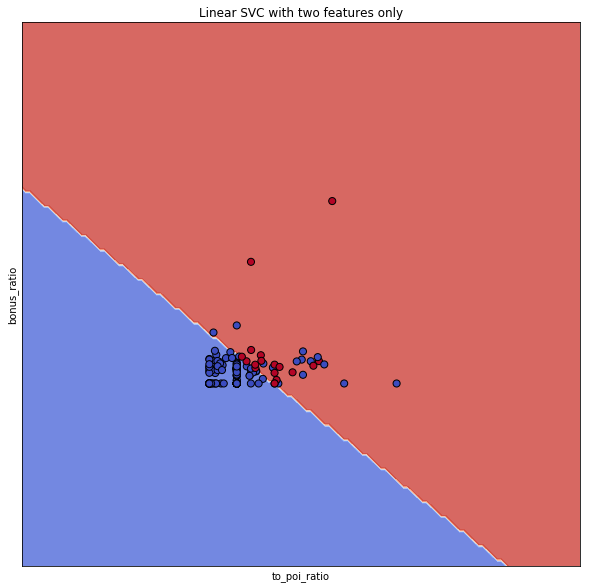

In [46]:
#based on https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    return xx, yy

Y_ = df.poi.values        
X_ = df.loc[:,['to_poi_ratio','bonus_ratio']].values
X_ = MinMaxScaler().fit_transform(X_)

clf=LinearSVC(class_weight='balanced',C=10)
clf=clf.fit(X_,Y_)

X0, X1 = X_[:, 0], X_[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig,ax=plt.subplots(figsize=(10,10))

v_=plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.8)
v_=ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
v_=ax.set_xlim(xx.min(), xx.max())
v_=ax.set_ylim(yy.min(), yy.max())
v_=ax.set_xlabel('to_poi_ratio')
v_=ax.set_ylabel('bonus_ratio')
v_=ax.set_xticks(())
v_=ax.set_yticks(())
v_=ax.set_title('Linear SVC with two features only')

We can rather easily count all red points on the figure: 15 among 18 (~80%) of POIs are allocated to the red zone. This figure is consistent with the recall score obtained above. So we can confirm visually that, with only two features, a SVM algorith is able to catch 80% of these POIs. Unfortunately, many non-POIs will be caught as well. We can see many blue points in the red zone. These blue ones are a little bit harder to count because there are too many of them or they overlap red ones. But we can roughly confirm that it is consistent with the low precision obtained above.

What's questionnable is why this pair of features is not systematically selected for others classifiers. Another question regarding feature selection is why EMAILS features are over-representated in the selection. For example, 'to_poi_ratio' is selected for all classifiers whatever is the score considered. And, for all selections, EMAILS fetaures represents the vast majority. Finnaly, STOCKS features are seldom used apart by GNB. 


- Finally, GNB performance is far lower than all other classifiers. 
- Using PCA decomposition instead of feature selection(see below) allows to greatly improve precision but recall drops from 10%.

In [47]:
for n in range(2,5):
    est = [('scale', MinMaxScaler()),('PCA',PCA(n_components=n)),('classifier', GaussianNB())]
    clf = Pipeline(steps=est)
    accuracy, precision, recall, f1, f2 = test_classifier(clf, my_dataset, ['poi']+list(FEATURES))
    print("n_PCA=%1.0f|acc=%1.2f,precision=%1.2f,recall=%1.2f,f1=%1.2f,f2=%1.2f" % (n,accuracy,precision,recall,f1,f2))

n_PCA=2|acc=0.88,precision=0.66,recall=0.26,f1=0.37,f2=0.29
n_PCA=3|acc=0.88,precision=0.66,recall=0.26,f1=0.37,f2=0.29
n_PCA=4|acc=0.88,precision=0.60,recall=0.23,f1=0.34,f2=0.27


## Tuning of classifiers
<a id='classif_eval_tuning'></a>

Based on the outcome of previous analysis, we'll focus on three classifiers:
- DTC which provides the best compromise. We'll also try to optimize more sophisticated algorithms based on the same core idea, e.g Random Forest and Adaboost with DTC with varying depth deepness.
- SVC for which non-linear kernels and corresponding parameters can be tested
- KNN because the precision reached is very high

### DTC  tuning

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Following three parameters are tuned:
- max_depth : The maximum depth of the tree. 
- min_samples_split : The minimum number of samples required to split an internal node
- max_features : The number of features to consider when looking for the best split:

Features are selected according to the outcome of the previous analysis; e.g the set of features which yield the best 'F1' score with default parameters for 'DecisionTreeClassifier' is used for parameters exploration.

In [48]:
X = df[FEATURES].values
Y = df.poi
my_dataset = df.transpose().to_dict()

def tune_classifier(classifier_id,classifier,features_selected,tuned_parameters,cv_n_iter,cv_scoring,
                    folds = 1000):

    estimator = [('scale', MinMaxScaler()),('classifier', classifier)]
    clf = Pipeline(steps=estimator)
    grid = GridSearchCV(clf, tuned_parameters, cv=StratifiedShuffleSplit(y=Y,n_iter=cv_n_iter,train_size=0.7),
                        scoring=cv_scoring,n_jobs=4)
    X_tune=df[features_selected].values
    grid = grid.fit(X_tune,Y)
    best_clf=grid.best_estimator_.named_steps['classifier']
    
    try:
        # if classifier can evaluate feature importance
        if classifier_id=='DecisionTreeClassifier':
            features_importances=best_clf.feature_importances_
        else:
            features_importances=best_clf.coef_
            features_importances=features_importances[0]
        # select only features with non null importance & rank per  importance
        n_feat_tuned=0
        for feature in features_importances:
            if abs(feature)>0:
                n_feat_tuned+=1
        features_tuned=[features_selected[i] for i in features_importances.argsort()][::-1]
        features_tuned=features_tuned[0:n_feat_tuned]

        # if classifier is a DTC and number of feature selected has decreased,
        # we need to update max_features
        if classifier_id=='DecisionTreeClassifier':
            if n_feat_tuned<best_clf.max_features_:
                best_clf.set_params(max_features=n_feat_tuned)            
    except:
        # otherwise features are not modified
        features_tuned = features_selected
        n_feat_tuned=len(features_tuned)
   
    # evaluate performance
    accuracy, precision, recall, f1, f2 = test_classifier(grid.best_estimator_, my_dataset, ['poi']+list(features_tuned),folds = folds)
    
    return [grid.best_params_,n_feat_tuned,features_tuned,cv_scoring,accuracy, precision, recall, f1, f2 ]

In [49]:
classifier_id = 'DecisionTreeClassifier'
# getting features already selected
n_features_selected = df_best_score.loc[classifier_id]['n feat.']
features_selected=(df_feature_score['RFE-DTC'].sort_values(ascending=False).index.values)[0:n_features_selected]

tuned_parameters=[{
        'classifier__max_depth':(range(3,8,1)),
        'classifier__max_features':(range(3,n_features_selected,1)),
        'classifier__min_samples_split':(range(2,6,2))}]

In [50]:
best_classifiers = defaultdict()

for i in range (0,10):
    best_classifiers[i]= tune_classifier(
                                            classifier_id = classifier_id,
                                            classifier=DecisionTreeClassifier(class_weight='balanced'),
                                            features_selected=features_selected,
                                            tuned_parameters=tuned_parameters,
                                            cv_n_iter = 100,
                                            cv_scoring='f1_micro')
    

df_tmp=pd.DataFrame(best_classifiers).transpose()
df_tmp.columns=['classifier','n feat.','features','cv score','acc','pres','recall','f1','f2']
df_tmp

,classifier,n feat.,features,cv score,acc,pres,recall,f1,f2
0,"{'classifier__max_depth': 5, 'classifier__max_features': 4, 'classifier__min_samples_split': 2}",5,"[to_poi_ratio, expenses, shared_receipt_with_poi, deferral_payments_ratio, from_poi_ratio]",f1_micro,0.920333,0.674318,0.7785,0.722673,0.755165
1,"{'classifier__max_depth': 6, 'classifier__max_features': 4, 'classifier__min_samples_split': 2}",5,"[to_poi_ratio, shared_receipt_with_poi, expenses, deferral_payments_ratio, from_poi_ratio]",f1_micro,0.926267,0.703182,0.7735,0.736667,0.758333
2,"{'classifier__max_depth': 6, 'classifier__max_features': 4, 'classifier__min_samples_split': 2}",5,"[to_poi_ratio, expenses, shared_receipt_with_poi, deferral_payments_ratio, from_poi_ratio]",f1_micro,0.9254,0.698871,0.774,0.73452,0.757709
3,"{'classifier__max_depth': 5, 'classifier__max_features': 3, 'classifier__min_samples_split': 2}",5,"[to_poi_ratio, shared_receipt_with_poi, expenses, from_poi_ratio, deferral_payments_ratio]",f1_micro,0.918867,0.672695,0.7625,0.714788,0.742671
4,"{'classifier__max_depth': 7, 'classifier__max_features': 4, 'classifier__min_samples_split': 4}",5,"[to_poi_ratio, expenses, shared_receipt_with_poi, deferral_payments_ratio, from_poi_ratio]",f1_micro,0.925933,0.703432,0.7685,0.734528,0.754541
5,"{'classifier__max_depth': 4, 'classifier__max_features': 4, 'classifier__min_samples_split': 2}",3,"[to_poi_ratio, expenses, shared_receipt_with_poi]",f1_micro,0.926733,0.695275,0.802,0.744834,0.778112
6,"{'classifier__max_depth': 7, 'classifier__max_features': 4, 'classifier__min_samples_split': 2}",5,"[to_poi_ratio, expenses, shared_receipt_with_poi, from_poi_ratio, deferral_payments_ratio]",f1_micro,0.922733,0.699952,0.736,0.717524,0.728496
7,"{'classifier__max_depth': 6, 'classifier__max_features': 4, 'classifier__min_samples_split': 4}",5,"[shared_receipt_with_poi, to_poi_ratio, from_poi_ratio, expenses, deferral_payments_ratio]",f1_micro,0.925667,0.697987,0.78,0.736718,0.762091
8,"{'classifier__max_depth': 7, 'classifier__max_features': 3, 'classifier__min_samples_split': 2}",5,"[to_poi_ratio, expenses, shared_receipt_with_poi, deferral_payments_ratio, from_poi_ratio]",f1_micro,0.920133,0.701103,0.699,0.70005,0.69942
9,"{'classifier__max_depth': 6, 'classifier__max_features': 4, 'classifier__min_samples_split': 4}",5,"[to_poi_ratio, expenses, from_poi_ratio, deferral_payments_ratio, shared_receipt_with_poi]",f1_micro,0.9252,0.698284,0.773,0.733745,0.756804


Ten different results are obtained for the 10 execution runs. Actually, this phenomenom can be explained because each execution run is not deterministic and independent from others ones. Actually, there are two distinct random generators in the tuning code above:
   - the one used by the decision tree algorithm itself 'DecisionTreeClassifier'
   - the one used by the grid search cross-validation algortithm which is a stratified shuffle 'StratifiedShuffleSplit'

None of these two generators have a frozen seed. Consequently, each execution run of the optimization algorithm can yield a different outcome. This is what we observed in the table above. However, parameters varies in a rather deterministic scale:
- max depth from 4 to 7 whereas exploration was set between 3 to 8
- max_features from 4 to 7 (vs 3 to 8)
- min splits from 2 to 4 (vs 2,4,6,8)

The random effect is more proeminent than the value of these parameters within this scale. We could smooth this effect by increasing the number of cross-validation splits but :
- it would result in a prohibitive computation time
- would likely lead to an overfitting because the whole inforamtion contained in the dataset would be used to train the classifier. And actually we likely have already reached this limit because the sample size is so small that 100 shuffles is already a lot.

As 'F1' score is in the same order of magnitude for all runs, the best option is to chose parameters which will be the least prone to overfitting: e.g lowest values of tree depth, lowest number of features and highest samples split :
- max_depth=4
- max_features=4
- min_samples_split=4
- coresponding features are: [to_poi_ratio, expenses, shared_receipt_with_poi, from_poi_to_this_person]   

In [51]:
# dot_data=tree.export_graphviz(best_classifiers['DTC']['run'==], out_file=None,feature_names=best_classifiers['DTC'][2],class_names=['NOT-poi','poi']) 
# print(dot_data)
# graphviz/dot doesn't work on my laptop
# need to cut & paste ouput in https://dreampuf.github.io/GraphvizOnline/

### SVC tuning

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    
We first tried to tune SVC algorithm with all kernels, but execution time is prohibitive. So we revert to liner kernal only and tuned the penalty parameter C of the error term.

This discussion on stack exchange explains the influence of C
https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
*"For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points"*

So we'll use the set of features which had high recall score (RFE-DTC and 11 features) and try to improve recall score. A smaller value of C is expected.

In [52]:
best_classifiers = defaultdict()
classifier_id = 'SVC'
# getting features already selected
# as we target to optimize 'recall' score we set the number of features to 11 (see results of feature selection)
n_features_selected = 4
features_selected=(df_feature_score['mean'].sort_values(ascending=False).index.values)[0:n_features_selected]

features_selected

#loss : string, ‘hinge’ or ‘squared_hinge’ (default=’squared_hinge’)
tuned_parameters=[{
        'classifier__C':[x/100 for x in range(10,100,10)],
}]

for i in range (0,5):
    print('Start run '+str(i+1))
    best_classifiers[i]= tune_classifier(
                                            classifier_id = classifier_id,
                                            classifier=LinearSVC(class_weight='balanced'),
                                            features_selected=features_selected,
                                            tuned_parameters=tuned_parameters,
                                            cv_n_iter = 100,
                                            cv_scoring='recall_macro')
    

df_tmp=pd.DataFrame(best_classifiers).transpose()
df_tmp.columns=['classifier','n feat.','features','cv score','acc','pres','recall','f1','f2']
df_tmp

array(['to_poi_ratio', 'shared_receipt_with_poi', 'bonus_ratio', 'bonus'],
      dtype=object)

Start run 1
Start run 2
Start run 3
Start run 4
Start run 5


,classifier,n feat.,features,cv score,acc,pres,recall,f1,f2
0,{'classifier__C': 0.5},4,"[to_poi_ratio, shared_receipt_with_poi, bonus_ratio, bonus]",recall_macro,0.847733,0.464518,0.9295,0.61946,0.774454
1,{'classifier__C': 0.9},4,"[to_poi_ratio, bonus_ratio, shared_receipt_with_poi, bonus]",recall_macro,0.846133,0.4619,0.9335,0.618007,0.775203
2,{'classifier__C': 0.8},4,"[to_poi_ratio, bonus_ratio, shared_receipt_with_poi, bonus]",recall_macro,0.8462,0.461977,0.9325,0.617857,0.774695
3,{'classifier__C': 0.1},4,"[to_poi_ratio, shared_receipt_with_poi, bonus, bonus_ratio]",recall_macro,0.840333,0.449527,0.8795,0.59496,0.738269
4,{'classifier__C': 0.5},4,"[to_poi_ratio, shared_receipt_with_poi, bonus_ratio, bonus]",recall_macro,0.847733,0.464518,0.9295,0.61946,0.774454


As expected, lower values of C provides better recall score. The range spreads from 0.4 to 0.8 for a tested range [0.1,1]. Once again, variations can be explained as independent executions are not deterministic. However compared to DTC, the variation is really low. We have alrady observed the robustness of this algorithm to feature selection.

Our final choice will then be 
- linear SVC with a C penalty paramter of 0.5 
- and 4 features [to_poi_ratio, shared_receipt_with_poi, bonus_ratio, deferred_income_ratio]

### KNN tuning

KNN is the classifier with the best precision found during feature selection. As a reminder, we reached more than 70% of precision with a recall aroud 55% and with 9 features selected through MIR

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

The most interesting parameter to tune is n_neighbors:
    - if we take 1, we should reach a maximal precision but implying variance and overfitting. 
    - if we take a bigger value, we'll smooth the classification decreasing variance but increasing bias
This article throws light upon this phenomenon: http://scott.fortmann-roe.com/docs/BiasVariance.html

To find a balance, we'll try to improve the precision while avoiding to reduce the recall score.

In [53]:

best_classifiers = defaultdict()
n_features_selected = 9
features_selected=(df_feature_score['MIR'].sort_values(ascending=False).index.values)[0:n_features_selected]

print('Features:',features_selected)

#loss : string, ‘hinge’ or ‘squared_hinge’ (default=’squared_hinge’)
tuned_parameters=[{
        'classifier__n_neighbors':(3,4,5,6,7)
}]

for i in range (0,5):
    print('Start run '+str(i+1))
    best_classifiers[i]= tune_classifier(
                                            classifier_id = classifier_id,
                                            classifier=KNeighborsClassifier(n_jobs=CPU_CORE),
                                            features_selected=features_selected,
                                            tuned_parameters=tuned_parameters,
                                            cv_n_iter = 100,
                                            cv_scoring='precision_macro',
                                            folds=1000)
    print(best_classifiers[i])

Features: ['shared_receipt_with_poi' 'to_poi_ratio' 'from_this_person_to_poi'
 'shared_poi_ratio' 'from_poi_ratio' 'email_ratio_poi' 'bonus'
 'from_poi_to_this_person' 'to_messages']
Start run 1
[{'classifier__n_neighbors': 5}, 9, array(['shared_receipt_with_poi', 'to_poi_ratio',
       'from_this_person_to_poi', 'shared_poi_ratio', 'from_poi_ratio',
       'email_ratio_poi', 'bonus', 'from_poi_to_this_person',
       'to_messages'], dtype=object), 'precision_macro', 0.8908, 0.6073546856465006, 0.512, 0.555615843733044, 0.5285979764608713]
Start run 2
[{'classifier__n_neighbors': 5}, 9, array(['shared_receipt_with_poi', 'to_poi_ratio',
       'from_this_person_to_poi', 'shared_poi_ratio', 'from_poi_ratio',
       'email_ratio_poi', 'bonus', 'from_poi_to_this_person',
       'to_messages'], dtype=object), 'precision_macro', 0.8908, 0.6073546856465006, 0.512, 0.555615843733044, 0.5285979764608713]
Start run 3
[{'classifier__n_neighbors': 7}, 9, array(['shared_receipt_with_poi', 'to_poi_r

In [54]:
df_tmp=pd.DataFrame()
df_tmp=pd.DataFrame(best_classifiers).transpose()
df_tmp.columns=['classifier','n feat.','features','cv score','acc','pres','recall','f1','f2']
df_tmp

,classifier,n feat.,features,cv score,acc,pres,recall,f1,f2
0,{'classifier__n_neighbors': 5},9,"[shared_receipt_with_poi, to_poi_ratio, from_this_person_to_poi, shared_poi_ratio, from_poi_ratio, email_ratio_poi, bonus, from_poi_to_this_person, to_messages]",precision_macro,0.8908,0.607355,0.512,0.555616,0.528598
1,{'classifier__n_neighbors': 5},9,"[shared_receipt_with_poi, to_poi_ratio, from_this_person_to_poi, shared_poi_ratio, from_poi_ratio, email_ratio_poi, bonus, from_poi_to_this_person, to_messages]",precision_macro,0.8908,0.607355,0.512,0.555616,0.528598
2,{'classifier__n_neighbors': 7},9,"[shared_receipt_with_poi, to_poi_ratio, from_this_person_to_poi, shared_poi_ratio, from_poi_ratio, email_ratio_poi, bonus, from_poi_to_this_person, to_messages]",precision_macro,0.887667,0.578554,0.58,0.579276,0.57971
3,{'classifier__n_neighbors': 7},9,"[shared_receipt_with_poi, to_poi_ratio, from_this_person_to_poi, shared_poi_ratio, from_poi_ratio, email_ratio_poi, bonus, from_poi_to_this_person, to_messages]",precision_macro,0.887667,0.578554,0.58,0.579276,0.57971
4,{'classifier__n_neighbors': 5},9,"[shared_receipt_with_poi, to_poi_ratio, from_this_person_to_poi, shared_poi_ratio, from_poi_ratio, email_ratio_poi, bonus, from_poi_to_this_person, to_messages]",precision_macro,0.8908,0.607355,0.512,0.555616,0.528598


Depending on the number of cross-validation, optimal number of neighbors can vary from 3 to 7. But the most frequent value is 5. So I guess that this is alréady the optimal value for precision scoring.

So at the end, KNN classifier is the same one as the one select during feature selection.

## Final cross-validation 
<a id="classif_final_cv"></a>

For final cross-validation, DTC is the most adequate candidate as it is the most balanced in terms of precision and recall. In addition, limiting the depth of the decision tree and the number of features involved in the decision at each step allows to limit overfitting and high variance. 


In [55]:
folds=1000
my_dataset = df.transpose().to_dict()

df_final_result=pd.DataFrame()
classifier_id = 'DecisionTreeClassifier'
features=['to_poi_ratio', 'expenses', 'shared_receipt_with_poi', 'from_poi_to_this_person'] 
lbl=['class_weight=balanced','max_depth=4','max_features=4','min_samples_split=4']
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=4,max_features=4,min_samples_split=4)

accuracy, precision, recall, f1, f2 = test_classifier(clf, my_dataset, ['poi']+list(features),folds=folds)
df_final_result['DTC']=[lbl,len(features),features,accuracy, precision, recall, f1, f2]

df_final_result=df_final_result.transpose()
df_final_result.columns=['parameters','n features','features','accuracy','precision','recall','f1','f2']
df_final_result

,parameters,n features,features,accuracy,precision,recall,f1,f2
DTC,"[class_weight=balanced, max_depth=4, max_features=4, min_samples_split=4]",4,"[to_poi_ratio, expenses, shared_receipt_with_poi, from_poi_to_this_person]",0.918067,0.662727,0.785,0.7187,0.757064


# Conclusion 
<a id='conclusion'></a>

The outcome of this study is that the classifer the most adequate to flag POIs is the Decision Tree Classifier. 

To select and tune this classifier, we proceeded as follows:
- we selected best features based on different selection methods. 
- we tuned the algorithm parameters to improve the different scores. 

Feature selection had the most significant impact on the performance of our classifiers. The benefit of parmaters tuning is only significant for SVC, for which recall score can be increased by setting down penalty paremeter.

All these steps have been supported by cross-validation always based on the same algorithm:
- shuffle stratified
- 70/30% train/test ratio
- 1000 folds for feature selection and 100 folds for parameters tuning

As the number of samples is small, it is very likely that features selection led to overfitting. Actually, during cross-validation, 1000 folds are used and which is huge considering the dataset size (about 150). Resulting samples are actually very representative of the whole dataset and we are thus extracting all the information when we apply such a high number of cross-validation. To limit this drawback, we could have limited the number of folds used for cross-validation during feature selection, but we would likely face the other drawback which is bias. 

Another option to limit overfitting is to reduce the depth of the decision tree and the number of features used for decision. That's the option we chose for the final Decision Tree Classifier by chosing following parameters:
- max_depth=4
- max_features=4
- min_samples_split=4
- an limiting to four features [to_poi_ratio, expenses, shared_receipt_with_poi, from_poi_to_this_person]   
Despite this mitigation, this classifier is likely still overfitted.

DTC performance is rather satisfactory and is the most balanced: F1 score is about 70% (see table above). This classifier will detect about 80% of all POIs and when it does flag someone as a POIs, it should be right about two third times.

Overvall ,it was a fun project even if it was really time consuming. Maybe I would have preferred to work on a bigger and more consistent database. Here, we can rapidly feel that data are a bit erratic and that the performance will be low. In addition the size of the database doesn't allow a proper and clean train/test process. We face a variance/bias dilemna since the very begining and had to choose a path.

Finally, we have neither explored nor attempted to classify POIs based on the email dataset. This database should be more complete and might lead to more efficient classifiers. But it is hard to say without trying! 

# Answers to questions
<a id='questions'></a>

***1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]***

Refer to introduction and following sections of the notebook:
1. [Explore, clean, improve and check dataset](#explore)
    - [Explore dataset](#explore)
    - [Clean dataset](#clean)
    - [Improve dataset](#improve)
    - [Outliers detection](#check)
    
***2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]***

Refer to following sections of the notebook:
2. [Features ranking](#features_select)
    - [Preliminary exploration](#features_select_explore)
    - [Filter methods](#features_select_explore)
    - [RFE methods](#features_select_explore)
    - [Embedded methods](#features_select_explore)

Regarding scaling, we used systematically a MinMaxScaler to scale features for each classifier. Classifers such as decision tree, don't  need it but as it has no adverse effect, it was the easiest way to proceed as we could the same funtion with scaling hard-coded. Some explorations have been conducted on others scalers: linear ones have an equivalent performance, and non-linear transformation don't work at all for this problem. This exploration is not recorded as it was clearly a dead end, there were no real added-value.

***3. *What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]***

Refer to following sections of the notebook:
2. [Features ranking](#features_select)
3. [Classifiers evaluation](#classif_eval)

***4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]***

Refer to following sections of the notebook:
3. [Classifiers evaluation](#classif_eval)
    - [Tuning of classifiers](#classif_eval_tuning)
    
**5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]***

Refer to following sections:
3. [Classifiers evaluation](#classif_eval)
    - [Final validation](#classif_final_cv)
[Conclusion](#conclusion)

***6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]***

Refer to following sections of the notebook:
3. [Classifiers evaluation](#classif_eval)
    - [Tuning of classifiers](#classif_eval_tuning)
    - [Final validation](#classif_final_cv)
4.  [Conclusion](#conclusion)